In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/bin/bash: chmod600: command not found


In [ ]:
!kaggle competitions download -c nfl-impact-detection

100% 3.02G/3.02G [00:18<00:00, 223MB/s]
100% 3.02G/3.02G [00:18<00:00, 176MB/s]


In [ ]:
!unzip nfl-impact-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/57830_000403_Sideline_frame0871.jpg  
  inflating: images/57830_000734_Endzone_frame60.jpg  
  inflating: images/57830_000734_Sideline_frame0520.jpg  
  inflating: images/57830_000734_Sideline_frame89.jpg  
  inflating: images/57830_000965_Endzone_frame192.jpg  
  inflating: images/57830_000965_Sideline_frame3.jpg  
  inflating: images/57830_001765_Sideline_frame0675.jpg  
  inflating: images/57830_002030_Endzone_frame496.jpg  
  inflating: images/57830_002030_Sideline_frame191.jpg  
  inflating: images/57830_002073_Endzone_frame1065.jpg  
  inflating: images/57830_002900_Endzone_frame166.jpg  
  inflating: images/57830_002900_Sideline_frame174.jpg  
  inflating: images/57830_002944_Endzone_frame0746.jpg  
  inflating: images/57831_000168_Endzone_frame0856.jpg  
  inflating: images/57831_000400_Endzone_frame0693.jpg  
  inflating: images/57831_000530_Endzone_frame47.jpg  
  inflating: images/57831_000530_Sideline_fr

In [ ]:
!kaggle datasets download -d daigohirooka/raft-pytorch

 75% 33.0M/44.0M [00:00<00:00, 106MB/s] 
100% 44.0M/44.0M [00:00<00:00, 114MB/s]


In [ ]:
!unzip raft-pytorch.zip

Archive:  raft-pytorch.zip
  inflating: raft-sintel.pth         
  inflating: raft-things.pth         
  inflating: raft/LICENSE            
  inflating: raft/RAFT.png           
  inflating: raft/README.md          
  inflating: raft/alt_cuda_corr/correlation.cpp  
  inflating: raft/alt_cuda_corr/correlation_kernel.cu  
  inflating: raft/alt_cuda_corr/setup.py  
  inflating: raft/chairs_split.txt   
  inflating: raft/config.py          
  inflating: raft/core/.ipynb_checkpoints/corr-checkpoint.py  
  inflating: raft/core/.ipynb_checkpoints/raft-checkpoint.py  
  inflating: raft/core/__init__.py   
  inflating: raft/core/corr.py       
  inflating: raft/core/datasets.py   
  inflating: raft/core/extractor.py  
  inflating: raft/core/raft.py       
  inflating: raft/core/update.py     
  inflating: raft/core/utils/.ipynb_checkpoints/flow_viz-checkpoint.py  
  inflating: raft/core/utils/__init__.py  
  inflating: raft/core/utils/augmentor.py  
  inflating: raft/core/utils/flow_viz.py  
 

In [ ]:
import os
import sys
sys.path.append('/kaggle/input/raft-pytorch')
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

from glob import glob
from PIL import Image
from tqdm import tqdm

In [ ]:
from raft.core.raft import RAFT
from raft.core.utils import flow_viz
from raft.core.utils.utils import InputPadder
from raft.config import RAFTConfig

In [ ]:
config = RAFTConfig(
    dropout=0,
    alternate_corr=False,
    small=False,
    mixed_precision=False
)

model = RAFT(config)
model

RAFT(
  (fnet): BasicEncoder(
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=Fa

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

weights_path = '/content/raft-sintel.pth'
weights_path = '/content/raft-things.pth'

ckpt = torch.load(weights_path, map_location=device)
model.to(device)
model.load_state_dict(ckpt)

device: cuda


<All keys matched successfully>

In [ ]:
image_files = glob('/content/sample images/*.jpg')
image_files = sorted(image_files)

print(f'Found {len(image_files)} images')
print(sorted(image_files))

Found 2 images
['/content/sample images/seq_000001.jpg', '/content/sample images/seq_000002.jpg']


In [ ]:
def load_image(imfile, device):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(device)


def viz(img1, img2, flo):
    img1 = img1[0].permute(1,2,0).cpu().numpy()
    img2 = img2[0].permute(1,2,0).cpu().numpy()
    flo = flo[0].permute(1,2,0).cpu().numpy()

    # map flow to rgb image
    flo = flow_viz.flow_to_image(flo)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
    ax1.set_title('input image1')
    ax1.imshow(img1.astype(int))
    ax2.set_title('input image2')
    ax2.imshow(img2.astype(int))
    ax3.set_title('estimated optical flow')
    ax3.imshow(flo)
    plt.show()

0it [00:00, ?it/s]

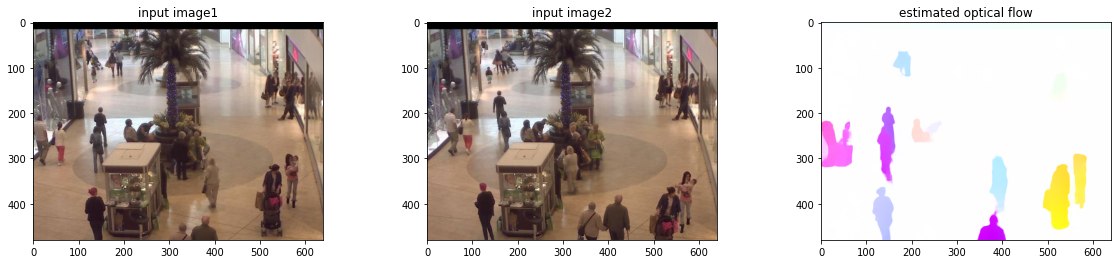

1it [00:00,  1.04it/s]


In [ ]:
model.eval()
n_vis = 3

for file1, file2 in tqdm(zip(image_files[:n_vis], image_files[1:1+n_vis])):
    image1 = load_image(file1, device)
    image2 = load_image(file2, device)

    padder = InputPadder(image1.shape)
    image1, image2 = padder.pad(image1, image2)

    with torch.no_grad():
        flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)

    viz(image1, image2, flow_up)

Run on NFL video

frame shape: (472, 720, 1280, 3)


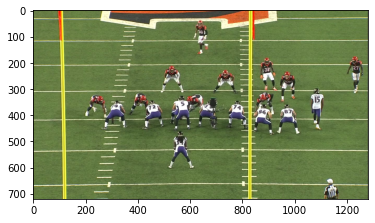

In [ ]:
video_file = '/content/train/57583_000082_Endzone.mp4'

cap = cv2.VideoCapture(video_file)

frames = []
while True:
    has_frame, image = cap.read()

    if has_frame:
        image = image[:, :, ::-1] # convert BGR -> RGB
        frames.append(image)
    else:
        break
frames = np.stack(frames, axis=0)

print(f'frame shape: {frames.shape}')
plt.imshow(frames[0])

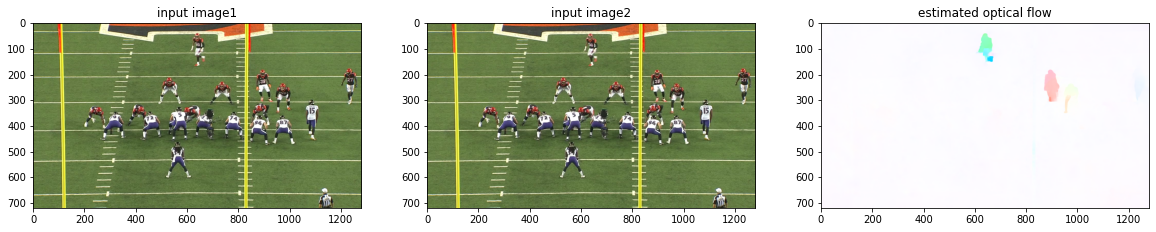

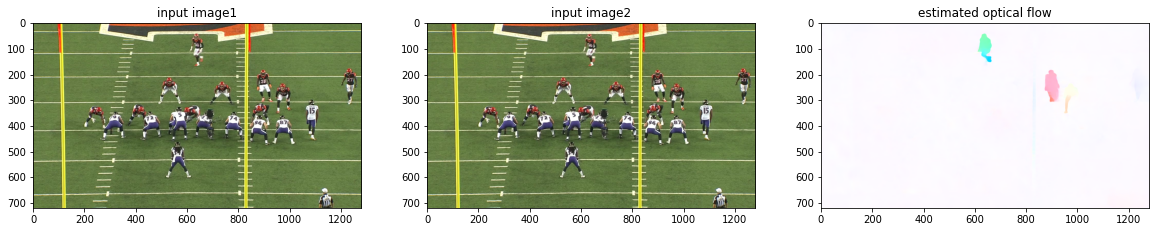

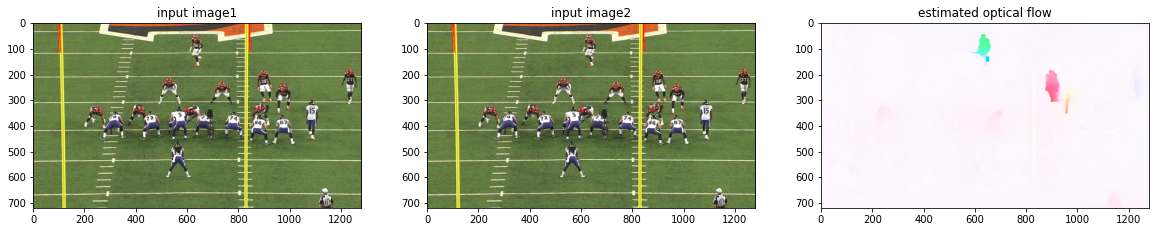

In [ ]:
n_vis = 3

for i in range(n_vis):
    image1 = torch.from_numpy(frames[i]).permute(2, 0, 1).float().to(device)
    image2 = torch.from_numpy(frames[i+1]).permute(2, 0, 1).float().to(device)

    image1 = image1[None].to(device)
    image2 = image2[None].to(device)

    padder = InputPadder(image1.shape)
    image1, image2 = padder.pad(image1, image2)

    with torch.no_grad():
        flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)

    viz(image1, image2, flow_up)

Now test the data


frame shape: (474, 720, 726, 3)


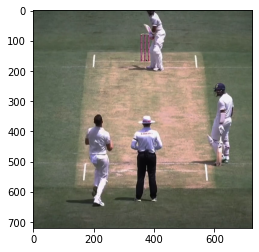

In [ ]:
video_file = '/content/Virat Kohli cover drive.mp4'

cap = cv2.VideoCapture(video_file)

frames = []
while True:
    has_frame, image = cap.read()

    if has_frame:
        image = image[:, :, ::-1] # convert BGR -> RGB
        frames.append(image)
    else:
        break
frames = np.stack(frames, axis=0)

print(f'frame shape: {frames.shape}')
plt.imshow(frames[0])

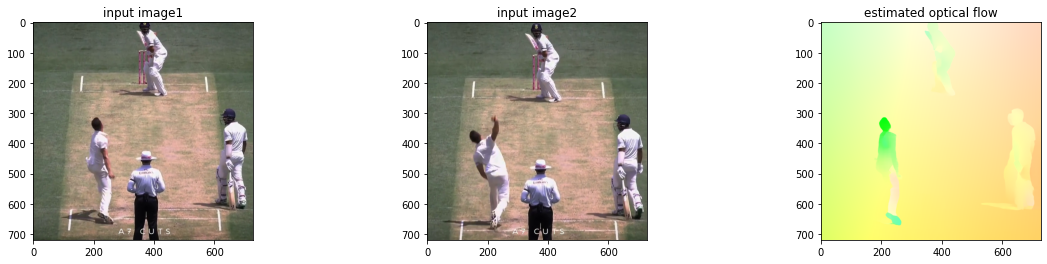

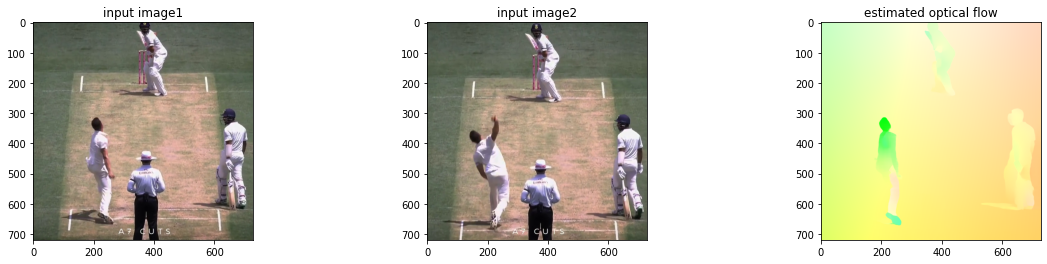

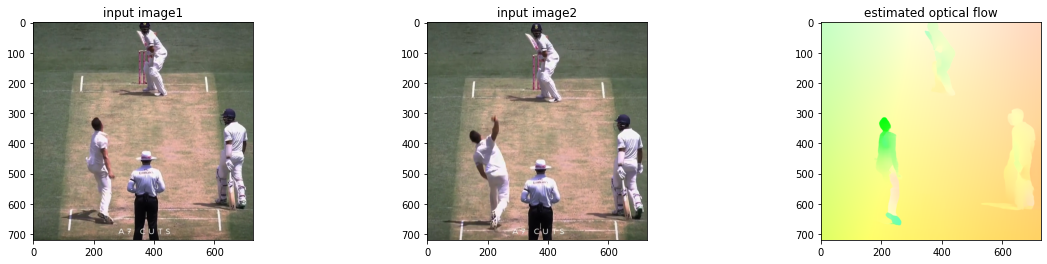

In [ ]:
n_vis = 3

for i in range(n_vis):
    image1 = torch.from_numpy(frames[i+100]).permute(2, 0, 1).float().to(device)
    image2 = torch.from_numpy(frames[i+120]).permute(2, 0, 1).float().to(device)

    image1 = image1[None].to(device)
    image2 = image2[None].to(device)

    padder = InputPadder(image1.shape)
    image1, image2 = padder.pad(image1, image2)

    with torch.no_grad():
        flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)

    viz(image1, image2, flow_up)

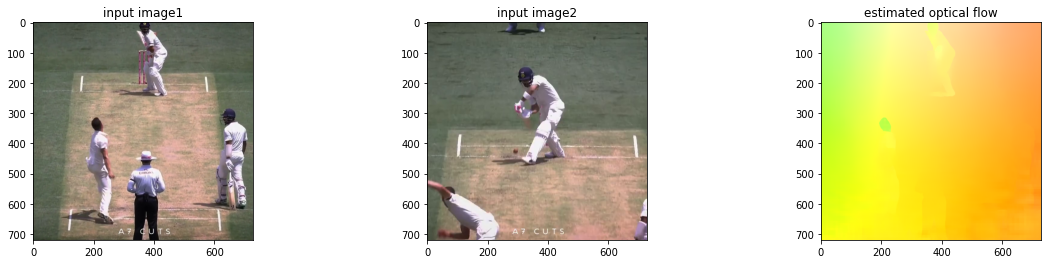

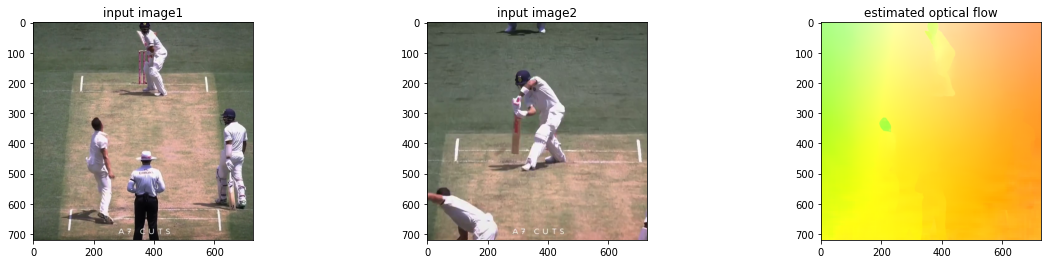

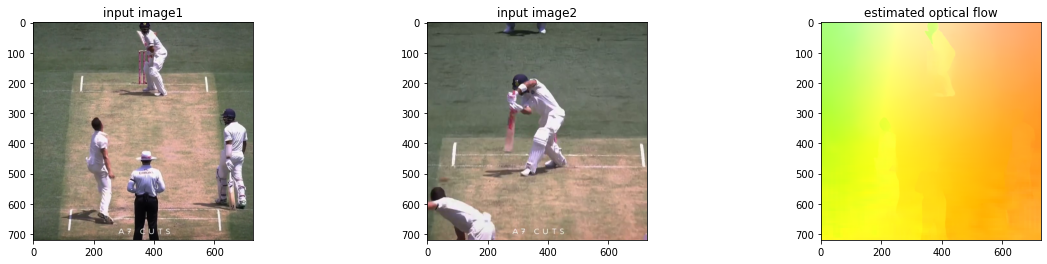

In [ ]:
n_vis = 3

for i in range(n_vis):
    image1 = torch.from_numpy(frames[i+100]).permute(2, 0, 1).float().to(device)
    image2 = torch.from_numpy(frames[i+160]).permute(2, 0, 1).float().to(device)

    image1 = image1[None].to(device)
    image2 = image2[None].to(device)

    padder = InputPadder(image1.shape)
    image1, image2 = padder.pad(image1, image2)

    with torch.no_grad():
        flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)

    viz(image1, image2, flow_up)